# Exploratory Data Analysis for the Zooplankton Dataset

In [286]:
# Load necessary libraries
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Environment variables
Filepath variables and constants for data processing update these as necessary

In [50]:
# File and folder locations
SRC_MASTER_CSV = r"C:\Users\Welcome\Documents\MScAC\STA2453\Project\CodeRepo\STA2453-Zooplankton\data\merged_csv\combined_lakes.csv"
DEST_TIFF_FOLDER = r"C:\Users\Welcome\Documents\MScAC\STA2453\Project\CodeRepo\STA2453-Zooplankton\data\combined_pics"

# Load Master CSV File
master_df = pd.read_csv(SRC_MASTER_CSV)
master_df['proc_tiff_file'] = master_df['csv_filepath'].astype(str) + "_" + master_df['Particle.ID'].astype(str) + ".tif"

In [51]:
# Filter out rows which do not have a corresponding demosaiced tif file
full_tiff_set = set(f for f in os.listdir(DEST_TIFF_FOLDER) if f.endswith((".tif", ".tiff")))

# Vectorized approach using .isin()
master_df['proc_image_exists'] = master_df['proc_tiff_file'].isin(full_tiff_set)

In [ ]:
# Simple check of results per lake
master_df[['proc_image_exists','lake']].value_counts()
#master_df['csv_filepath'].astype(str) + "_" + master_df['Particle.ID'].astype(str) + ".tif"

proc_image_exists  lake  
True               Huron     1001471
False              Simcoe     993391
True               Simcoe     246187
False              Huron       50206
Name: count, dtype: int64

In [ ]:
# Ensure only samples with an image are kept
filtered_df = master_df[master_df['proc_image_exists'] == True]

## Numerical Features
Create class histogram\
Note high-lelvel of class imbalance

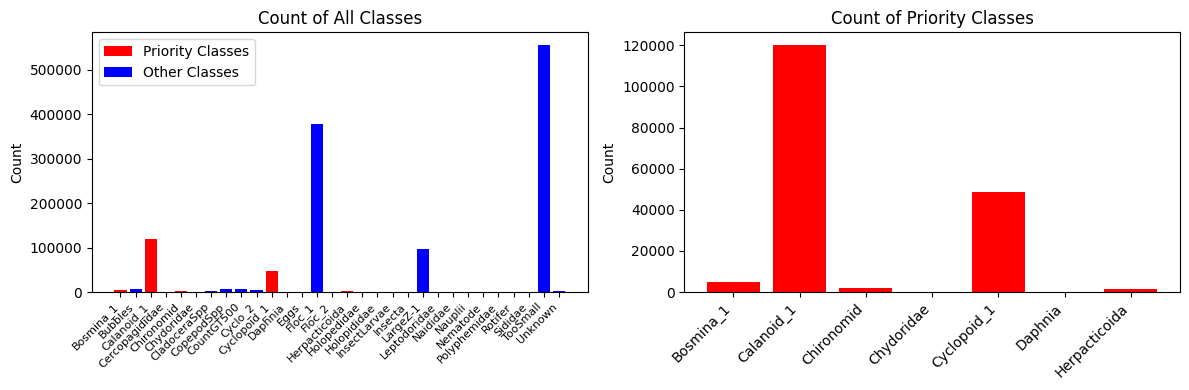

In [ ]:
# Define priority classes and colors
priority_classes = ['Calanoid_1', 'Cyclopoid_1', 'Bosmina_1', 'Herpacticoida', 'Chydoridae', 'Chironomid', 'Daphnia']

priority_df = filtered_df[filtered_df['Class'].isin(priority_classes)]
all_classes = filtered_df.groupby('Class', as_index = False).aggregate(Instances = ('Class.Particle.ID','count'))

colors = ['red' if c in priority_classes else 'blue' for c in all_classes['Class']]


# Build Figure
plt.figure(figsize=(12,4))
# First subplot - all classes
plt.subplot(1,2,1)
plt.bar(all_classes['Class'], all_classes['Instances'], color=colors)
plt.xticks(rotation=45, ha='right')
plt.title('Count of All Classes')
plt.ylabel('Count')
priority_patch = plt.Rectangle((0,0), 1, 1, fc='red', label='Priority Classes')
other_patch = plt.Rectangle((0,0), 1, 1, fc='blue', label='Other Classes')
plt.legend(handles=[priority_patch, other_patch])
plt.tick_params(axis='x', labelsize=8)
plt.tight_layout()

# Second subplot - priority classes only
plt.subplot(1,2,2)
priority_hist = all_classes[all_classes['Class'].isin(priority_classes)]
plt.bar(priority_hist['Class'], priority_hist['Instances'], color='red')
plt.xticks(rotation=45, ha='right')
plt.title('Count of Priority Classes')
plt.ylabel('Count')
plt.tight_layout()

plt.show()

## High-level correlation heatmap


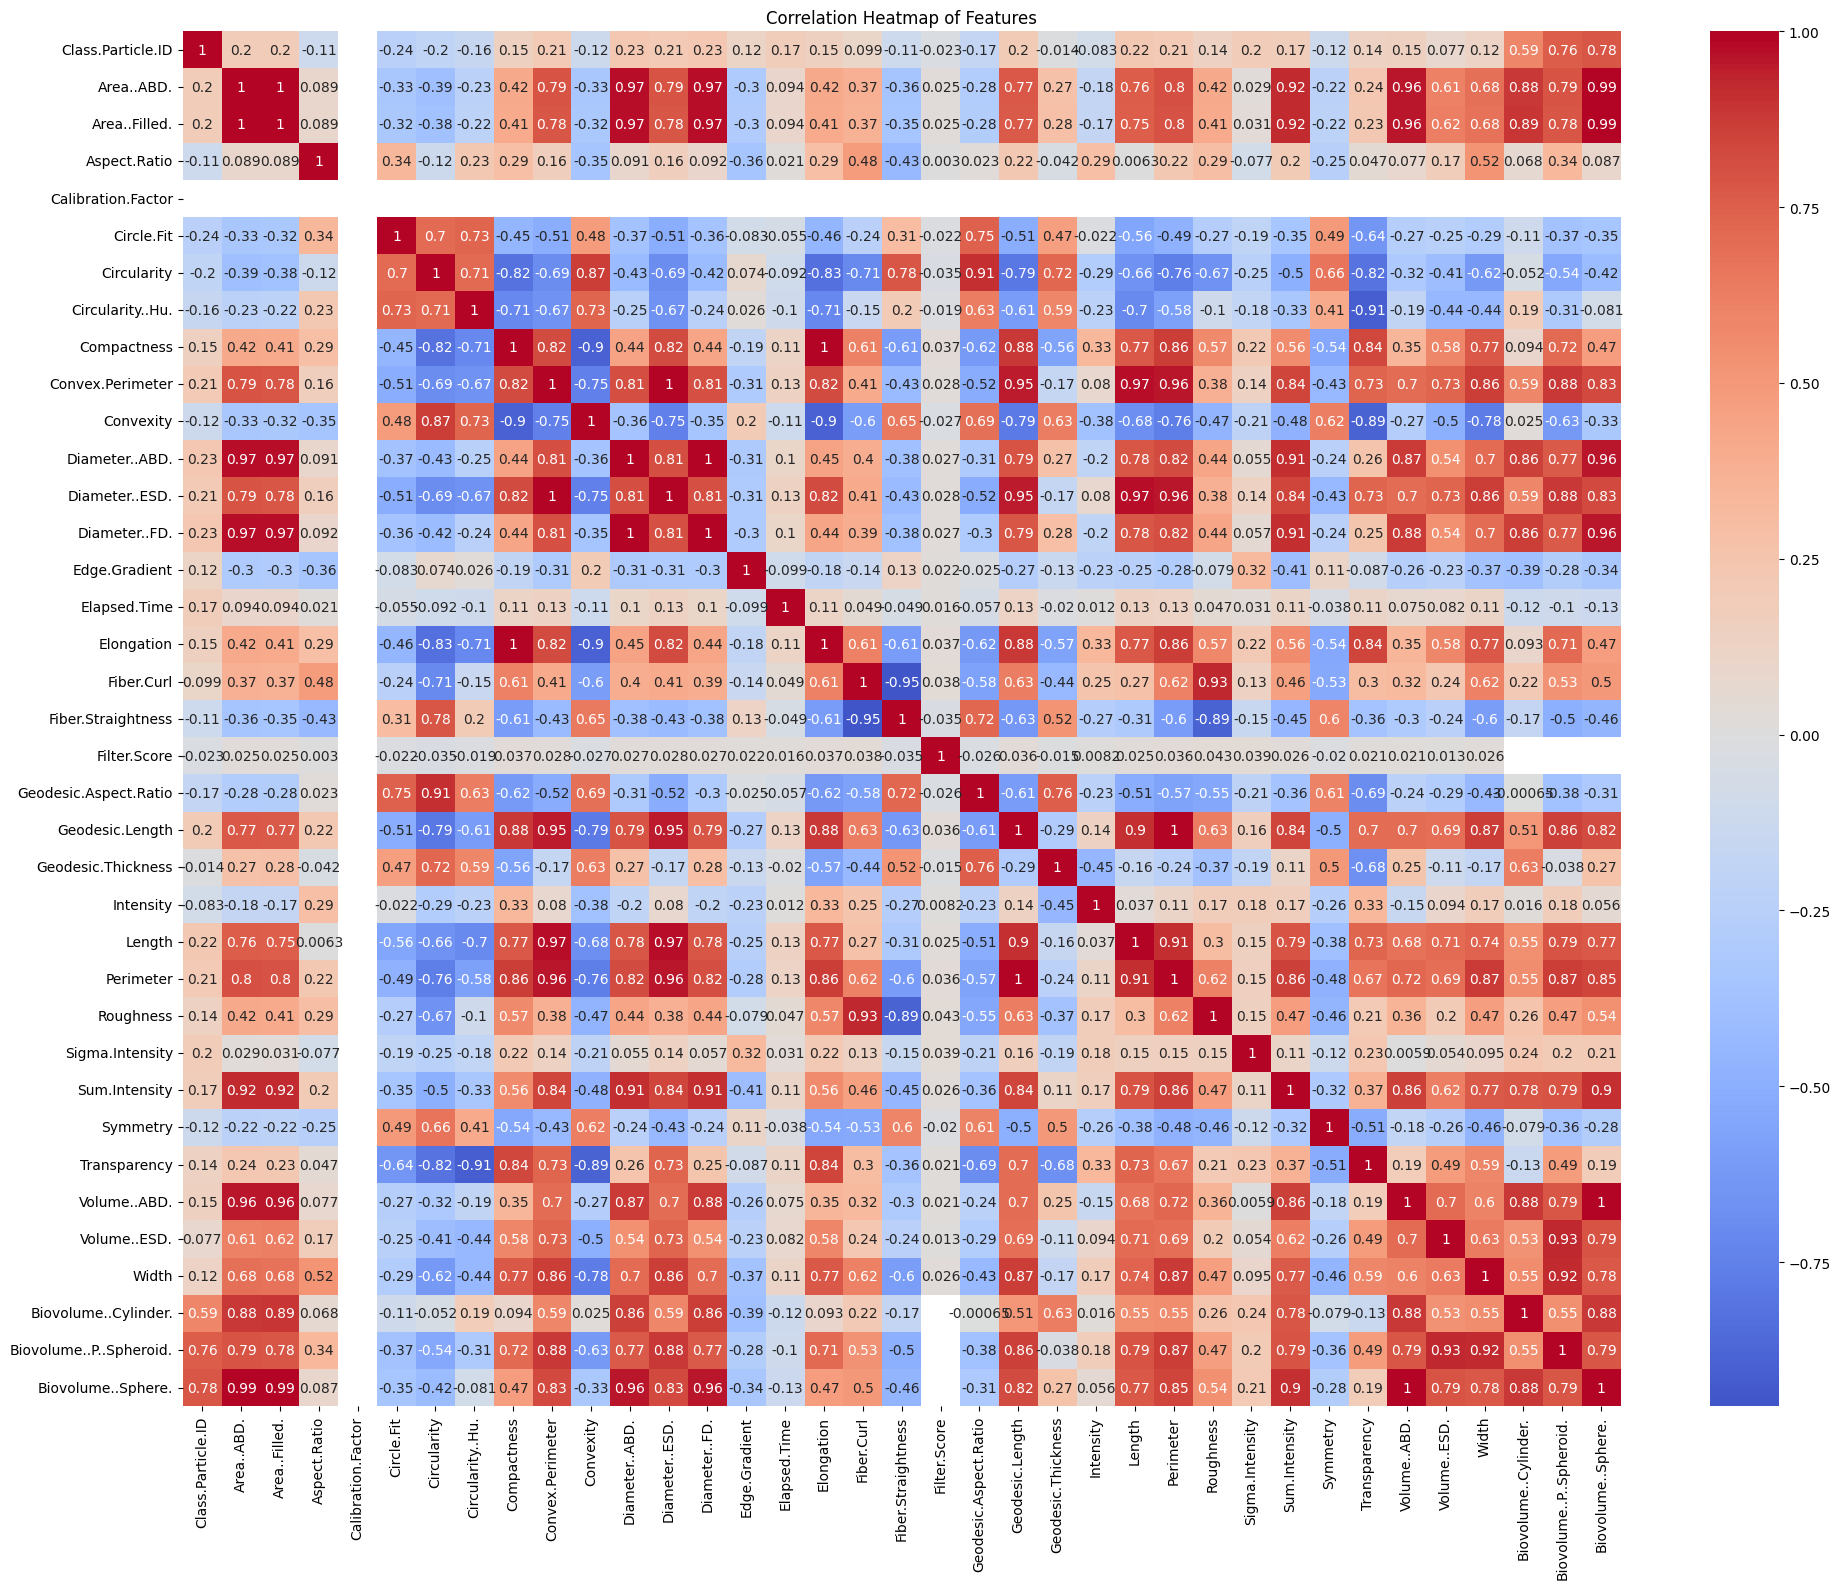

In [81]:
float_columns = priority_df.select_dtypes(include=['float']).columns.tolist()


plt.figure(figsize=(20, 16))
sns.heatmap(priority_df[float_columns].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()

## Create histograms for individual numerical features
Save outputs to png files

In [ ]:
for col_index in range(priority_df[float_columns].shape[1]):
    plt.figure(figsize=(12, 6))
    sns.kdeplot(data=priority_df[float_columns].iloc[:, col_index], fill=True)
    plt.title(f'Distribution of {priority_df[float_columns].columns[col_index]}')
    plt.xlabel(priority_df[float_columns].columns[col_index])
    plt.ylabel('Density')

    # Save the figure with the column name in the filename
    filename = f"data/figures/distribution_{priority_df[float_columns].columns[col_index]}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    #plt.show()
    # Close the figure to free memory
    plt.close()

    print(f"Saved: {filename}")  # Optional: Print confirmation


print(priority_df[float_columns].columns)

## TIFF Exploration
*Warning below cell takes a long time to run*

In [93]:
# Read in all images, get their shape

def get_image_size_cv2(image_path):
    file_path = DEST_TIFF_FOLDER + "\\" + image_path
    try:
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Read the image
        if img is not None:
            return img.shape[1], img.shape[0]  # (width, height)
        else:
            return None  # Handle missing/corrupt images
    except Exception:
        return None
    
filtered_df['image_size'] = filtered_df['proc_tiff_file'].swifter.apply(get_image_size_cv2)
filtered_df[['width', 'height']] = pd.DataFrame(filtered_df['image_size'].tolist(), index=filtered_df.index)

# Drop the intermediate column
filtered_df.drop(columns=['image_size'], inplace=True)
filtered_df['Priority_Class'] = np.where(filtered_df['Class'].isin(priority_classes), filtered_df['Class'], 'Other')
# Save the csv
#filtered_df.to_csv(r"C:\Users\Welcome\Documents\MScAC\STA2453\Project\CodeRepo\STA2453-Zooplankton\data\merged_csv\filtered_df")


Pandas Apply: 100%|██████████| 1247658/1247658 [3:07:51<00:00, 110.69it/s] 
C:\Users\Welcome\AppData\Local\Temp\ipykernel_14184\2621000047.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['image_size'] = filtered_df['proc_tiff_file'].swifter.apply(get_image_size_cv2)
C:\Users\Welcome\AppData\Local\Temp\ipykernel_14184\2621000047.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[['width', 'height']] = pd.DataFrame(filtered_df['image_size'].tolist(), index=filtered_df.index)
C:\

## Create visual based on image dimensions
Notice majority of density around the 50x50 image size

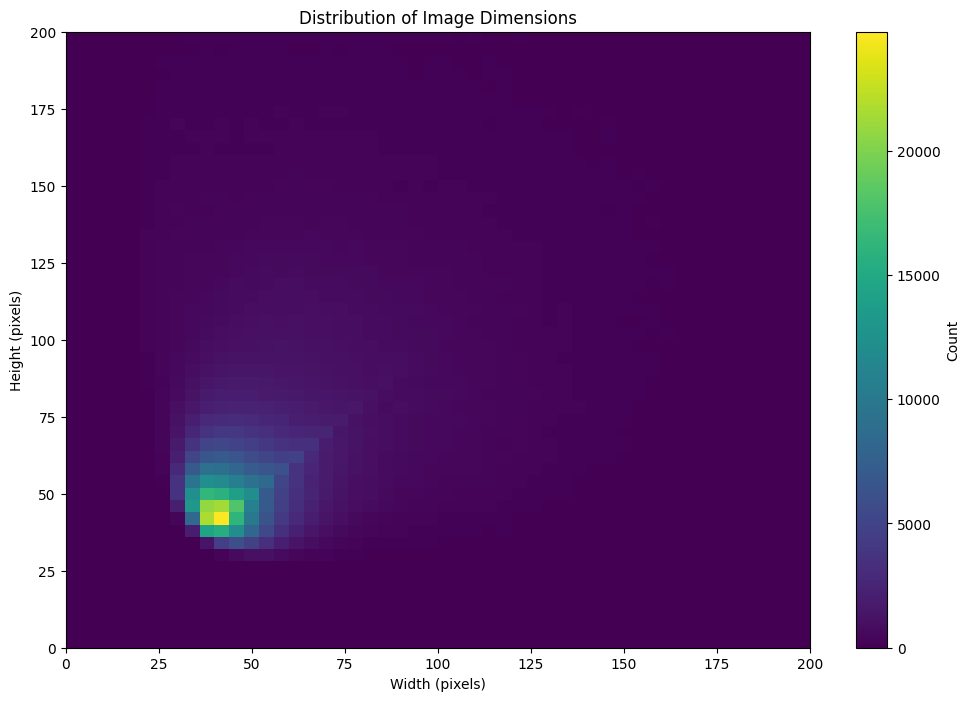

In [272]:
filtered_df = filtered_df.dropna(subset=['width','height'])

bins = 50  # Number of bins
max_bin = 200  # Cap at 200+ pixels

# Create a 2D histogram (heatmap) of image dimensions
plt.figure(figsize=(12, 8))
plt.hist2d(
    filtered_df['width'],#.clip(upper=max_bin),  # Cap width at 200 pixels
    filtered_df['height'],#.clip(upper=max_bin),  # Cap height at 200 pixels
    bins=(bins, bins),  
    range=[[0, max_bin], [0, max_bin]],  # Ensure binning stops at 200
    cmap='viridis'#,
    #density = True
)
plt.colorbar(label='Count')

plt.title('Distribution of Image Dimensions')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')

# Show or save the figure
plt.show()
# plt.savefig('data/figures/image_dimensions_heatmap.png', dpi=300, bbox_inches='tight')
plt.close()


## Density plot for each of the priority plankton classes
Clearly a lot can be learned from just hte dimension of the image. One compounding reason to use the numeric features

Text(0, 0.5, 'Density')

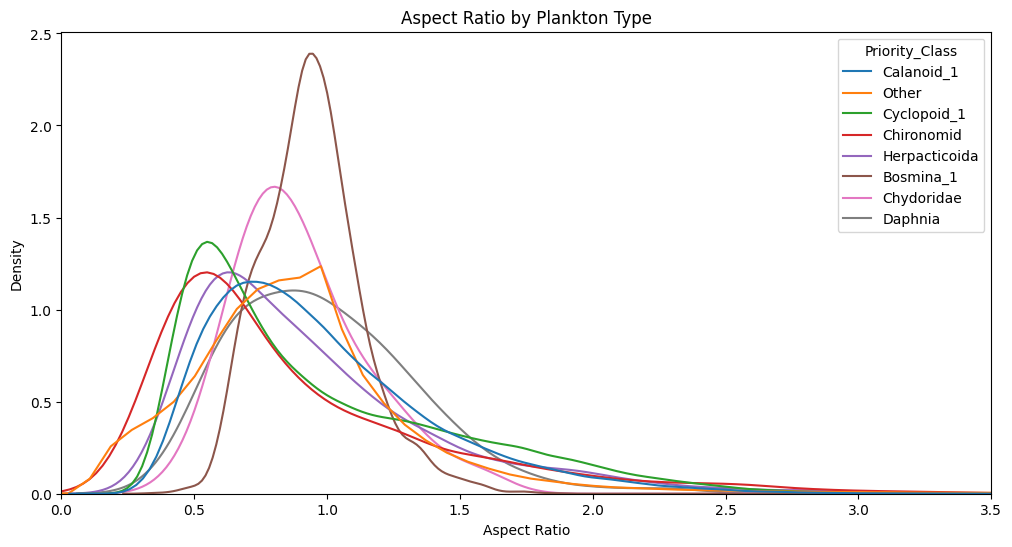

In [133]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=filtered_df, x='aspect_ratio', hue='Priority_Class', common_norm=False)
plt.title(f'Aspect Ratio by Plankton Type')
plt.xlim((0,3.5))
plt.xlabel('Aspect Ratio')
plt.ylabel('Density')

## Distribution of image dimensions for a given zooplankton class

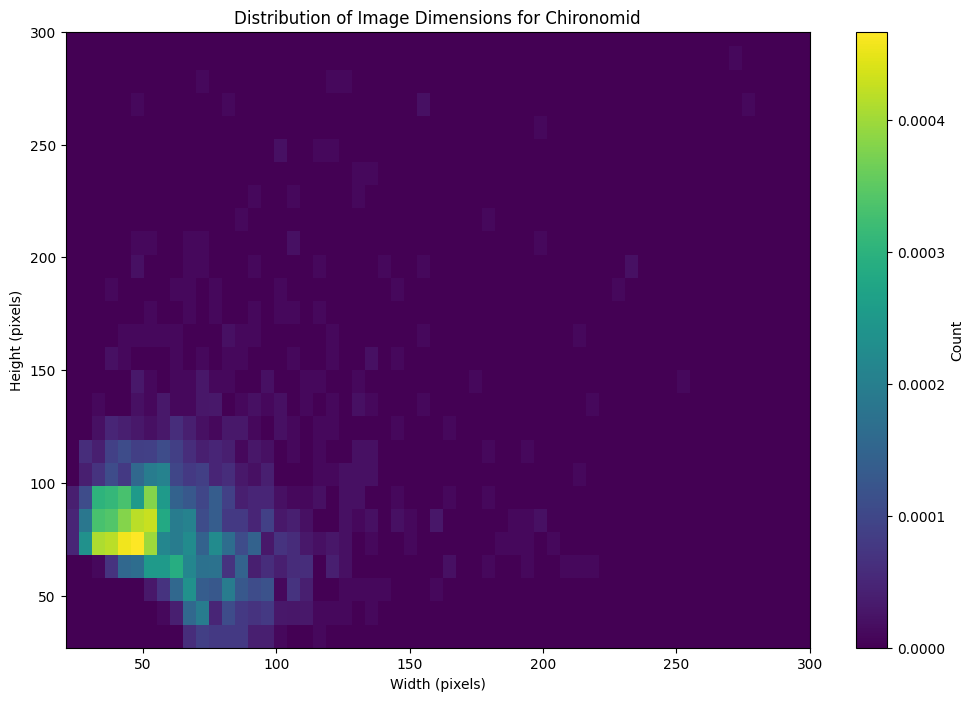

In [280]:
CLASS_OF_INTEREST = 'Chironomid'
filtered_df = filtered_df.dropna(subset=['width','height'])

class_df = filtered_df[filtered_df['Class'] == CLASS_OF_INTEREST]
bins = 100  # Number of bins
max_bin = 200  # Cap at 200+ pixels

# Create a 2D histogram (heatmap) of image dimensions
plt.figure(figsize=(12, 8))
plt.hist2d(
    class_df['width'],#.clip(upper=max_bin),  # Cap width at 200 pixels
    class_df['height'],#.clip(upper=max_bin),  # Cap height at 200 pixels
    bins=(bins, bins),  
    #range=[[0, max_bin], [0, max_bin]],  # Ensure binning stops at 200
    cmap='viridis',
    density = True
)
plt.colorbar(label='Count')

plt.title('Distribution of Image Dimensions for ' + CLASS_OF_INTEREST)
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.xlim((min(class_df['width']),300))
plt.ylim((min(class_df['height']),300))

# Show or save the figure
plt.show()
# plt.savefig('data/figures/image_dimensions_heatmap.png', dpi=300, bbox_inches='tight')
plt.close()


### Performing PCA on images
First pick a Zooplankton class, then run PCA on the class subset of the data.

In [ ]:
# Pick the class of interest
#class_of_interest = 'Cyclopoid_1'
class_df = filtered_df[filtered_df['Class'] == CLASS_OF_INTEREST][['tiff_fp','proc_tiff_file']]

# Normalized dimensions of image
WIDTH = 40
HEIGHT = 70
IMAGE_DIM = (WIDTH,HEIGHT)

# Helper function to collect the image
def image_proc(image_path):
    try:
        file_path = DEST_TIFF_FOLDER + "\\" + image_path
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale
        img = cv2.resize(img, IMAGE_DIM)
        return img.flatten()
    except:
        return -1


# Collect flattened images and filter out failed reads
class_df['flattened_img'] = class_df['proc_tiff_file'].astype(str).swifter.apply(image_proc)
class_df = class_df[class_df['flattened_img'].apply(lambda x: isinstance(x,np.ndarray))]

# Stack flattened images into 1 matrix
class_specific_np = np.stack(class_df['flattened_img'].to_numpy())

# Uncomment below line to save csv
#class_df.to_csv(r'C:\Users\Welcome\Documents\MScAC\STA2453\Project\CodeRepo\STA2453-Zooplankton\data\merged_csv\resized_Bosmina.csv')


Pandas Apply: 100%|██████████| 2057/2057 [00:38<00:00, 53.72it/s]


In [ ]:
# Perform PCA using sci-kit learn package
N_COMPONENTS = 5
pca = PCA(n_components= N_COMPONENTS)
pca.fit(class_specific_np)

PCA(n_components=5)

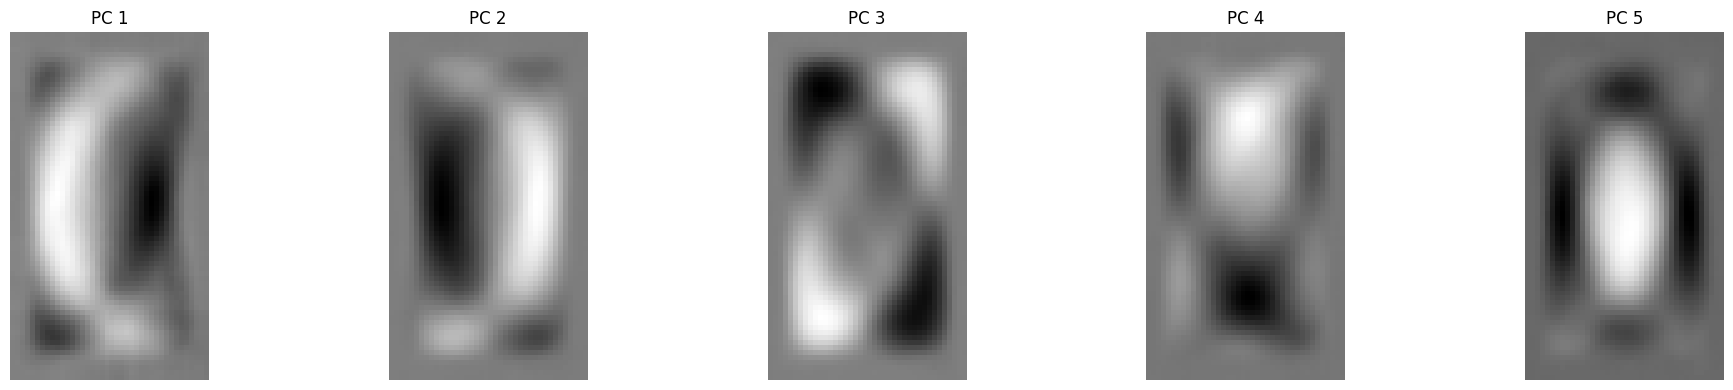

In [283]:
# Get the components and reshape them to original image dimensions
components = pca.components_
n_components = components.shape[0]

plt.figure(figsize=(20, 4))
for i in range(n_components):
    component = components[i].reshape(HEIGHT, WIDTH)  # Reshape to original dimensions
    
    # Normalize component to 0-255 range for visualization
    component = ((component - component.min()) * 255 / (component.max() - component.min())).astype(np.uint8)
    
    plt.subplot(1, n_components, i+1)
    plt.imshow(component, cmap='gray')
    plt.title(f'PC {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


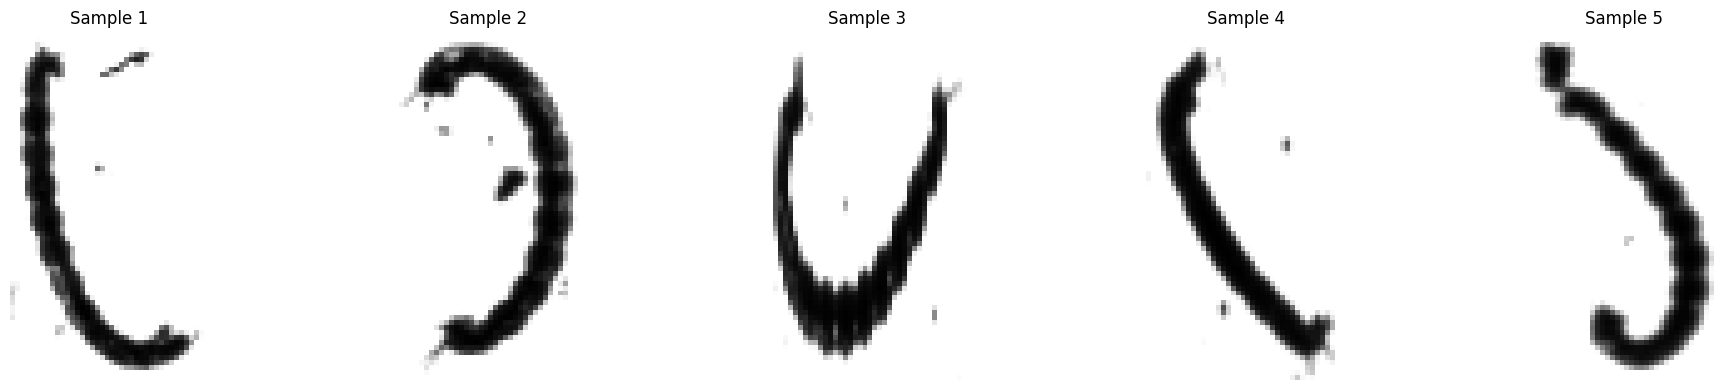

In [285]:
# Get collection of original samples for the class
plt.figure(figsize=(20, 4))

components = class_specific_np[0:5,:]
n_components = components.shape[0]
for i in range(n_components):
    component = components[i].reshape(HEIGHT, WIDTH)  # Reshape to original dimensions
    
    # Normalize component to 0-255 range for visualization
    #component = ((component - component.min()) * 255 / (component.max() - component.min())).astype(np.uint8)
    
    plt.subplot(1, n_components, i+1)
    plt.imshow(component, cmap='gray')
    plt.title(f'Sample {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Prep processed data set for training

In [10]:
import pandas as pd
import numpy as np
import os

master_df = pd.read_csv(r'C:\Users\Welcome\Documents\MScAC\STA2453\Project\CodeRepo\STA2453-Zooplankton\data\merged_csv\combined_lakes.csv')
priority_classes = ['Calanoid_1', 'Cyclopoid_1', 'Bosmina_1', 'Herpacticoida', 'Chydoridae', 'Chironomid', 'Daphnia', 'TooSmall', 'lowPriority']

# Create helper columns
master_df['priority_class'] = np.where(master_df['Class'].isin(priority_classes), master_df['Class'], 'lowPriority')
master_df.rename(columns={'Particle.ID': 'Particle_ID'}, inplace=True)
master_df['priority_class'][0] + "/" + master_df['csv_filepath'][0] + "_" + str(master_df['Particle_ID'][0]) + ".tif"
master_df['resized_filepath'] = master_df['priority_class'] + "/" + master_df['csv_filepath'] + "_" + master_df['Particle_ID'].astype(str) + ".tif"

FOLDER =r"C:\Users\Welcome\Documents\MScAC\STA2453\Project\CodeRepo\STA2453-Zooplankton\data\EfficientNetTrain"

# Filter master_df to keep only rows with existing file paths
mask = master_df['resized_filepath'].apply(lambda x: os.path.exists(os.path.join(FOLDER, x)))
master_df = master_df[mask].copy()




In [11]:
# Feature normalization
# Define feature columns
FEATURE_COLS = [
    'Area..ABD.', 'Area..Filled.',
    'Aspect.Ratio', 'Calibration.Factor', 'Calibration.Image',
    'Circle.Fit', 'Circularity', 'Circularity..Hu.', 'Compactness',
    'Convex.Perimeter', 'Convexity', 'Diameter..ABD.', 'Diameter..ESD.',
    'Diameter..FD.', 'Edge.Gradient', 'Elongation', 'Feret.Angle.Max',
    'Feret.Angle.Min', 'Fiber.Curl', 'Fiber.Straightness', 'Filter.Score',
    'Geodesic.Aspect.Ratio', 'Geodesic.Length', 'Geodesic.Thickness',
    'Image.Height', 'Image.Width', 'Intensity', 'Length',
    'Particles.Per.Chain', 'Perimeter', 'Roughness', 'Sigma.Intensity',
    'Source.Image', 'Sphere.Complement', 'Sphere.Count', 'Sphere.Unknown',
    'Sphere.Volume', 'Sum.Intensity', 'Symmetry', 'Transparency',
    'Volume..ABD.', 'Volume..ESD.', 'Width']

# Normalize features using min-max scaling
for col in FEATURE_COLS:
    if col in master_df.columns:
        min_val = master_df[col].min()
        max_val = master_df[col].max()
        if max_val > min_val:  # Avoid division by zero
            master_df[col] = (master_df[col] - min_val) / (max_val - min_val)
        else:
            master_df[col] = 0  # If all values are the same, set to 0

#Add factorized representation of class label
master_df['int_labels'] = pd.factorize(master_df['priority_class'])[0]

master_df.to_csv(r'C:\Users\Welcome\Documents\MScAC\STA2453\Project\CodeRepo\STA2453-Zooplankton\data\merged_csv\combined_data.csv')

1235064
